In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_excel("./data/Sample_Longlist_Data.xlsx")
data.head(5)

,Date Added,category,sellerlink,sellerlink-url,sellerstorefront-url,sellerproductcount,sellerratings,sellerdetails,seller business name,businessaddress,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,Sample brand name,Sample Brand URL
0,2020-11-15,Garden,Seller 1,Seller 1-link,Seller 1-storefrontlink,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),Lohas Living Inc James Mazzello US 845 3RD Ave...,Business Name:Lohas Living Inc,411 THEODORE FREMD AVESTE 206 SOUTHRyeNY10580-...,16,17,11,12,5873,4957,Visit the YAMAZAKI Store,https://www.amazon.de/-/en/stores/YAMAZAKI/pag...
1,2020-11-15,Garden,Seller 2,Seller 2-link,Seller 2-storefrontlink,NaN,90% positive in the last 12 months (566 ratings),Herzlich Willkommen im Amazon Shop von 1a-Hand...,Business Name:1a-Handelsagentur,1a HandelsagenturLindenallee 2MalchowMecklenbu...,0,2,2,9,0,0,Visit the tesa Store,https://www.amazon.de/-/en/stores/tesa/page/12...
2,2020-11-15,Garden,Seller 3,Seller 3-link,Seller 3-storefrontlink,"1-16 of over 2,000 results",85% positive in the last 12 months (75 ratings),67878u6i7 is committed to providing each custo...,Business Name:nantongaohuanfangzhipinyouxiango...,zhongnanshijicheng27zhuang1410haochongchuanqun...,15,0,25,12,164,162,TXYFYP,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...
3,2020-11-15,Garden,Seller 4,Seller 4-link,Seller 4-storefrontlink,1-16 of 123 results,NaN,7 days home life supermarket is committed to p...,Business Name:Zhengzhou Yaoqiong Trading Company,河南省中兴南路福禄街自贸试验区郑州片区（郑东）河南商会大厦1901室450000CN,1,0,0,0,0,0,SHIFENG,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...
4,2020-11-15,Garden,Seller 5,Seller 5-link,Seller 5-storefrontlink,"1-16 of over 1,000 results",81% positive in the last 12 months (52 ratings),78 68yui678 is committed to providing each cus...,Business Name:shenzhenfeichangshangmeimaoyiyou...,minzhidadaoshaxialaocun94dongA901longhuaxinqus...,16,0,31,15,224,113,YUOKI99,https://www.amazon.de/-/en/s/ref=bl_dp_s_web_0...


In [3]:
# extract email and phone number
contact = data[["sellerlink", "sellerdetails"]].copy()

contact["email"] = [
    re.findall(r"[\w.+-]+@[\w-]+\.[\w.-]+", row)
    for row in contact["sellerdetails"].fillna("")
]
contact["email"] = contact["email"].apply(set)

contact["phone_number"] = [
    re.findall(r"[\+\(]?[0-9][0-9 \-\(\)]{8,}[0-9]", row)
    for row in contact["sellerdetails"].fillna("")
]
contact["phone_number"] = contact["phone_number"].apply(
    lambda numbers: {number.replace(" ", "") for number in numbers}
)

del contact["sellerdetails"]
contact.head(2)

,sellerlink,email,phone_number
0,Seller 1,{jadgemaello@gmail.com},"{30-0961431, 10022-6630, +1208-964-6807}"
1,Seller 2,{info@1a-handelsagentur.de},{039932-829721}


In [4]:
data.drop(
    columns=[
        "category",
        "Date Added",
        "sellerlink-url",
        "sellerstorefront-url",
        "seller business name",
        "sellerdetails",
        "Sample brand name",
        "Sample Brand URL",
    ],
    inplace=True,
)

# Extract Geography Information

In [5]:
"""
extracting zipcode and country
"""


def geography(address):
    if pd.isnull(address):
        return None, None

    country_code = address[-2:]
    zipcode = re.findall(f"(\d+(?:-\d+)?)(?={country_code})", address)
    zipcode = zipcode[0] if zipcode else np.nan
    return country_code, zipcode


data[["country", "zipcode"]] = data["businessaddress"].apply(geography).apply(pd.Series)
del data["businessaddress"]

data.head(2)

,sellerlink,sellerproductcount,sellerratings,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode
0,Seller 1,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),16,17,11,12,5873,4957,US,10580-1410
1,Seller 2,NaN,90% positive in the last 12 months (566 ratings),0,2,2,9,0,0,DE,17213


In [6]:
# extract country codes from business address
decoded_country_codes = {
    "AT": "Austria",
    "AU": "Australia",
    "BE": "Belgium",
    "CH": "Switzerland",
    "CN": "China",
    "CZ": "Czech Republic",
    "DE": "Germany",
    "ES": "Spain",
    "FR": "France",
    "GB": "United Kingdom",
    "HK": "Hong Kong",
    "IE": "Ireland",
    "IN": "India",
    "IT": "Italy",
    "JP": "Japan",
    "NL": "Netherlands",
    "PL": "Poland",
    "PT": "Portugal",
    "SE": "Sweden",
    "TH": "Thailand",
    "US": "United States",
}

data["country"] = data["country"].map(decoded_country_codes)
data.head(2)

,sellerlink,sellerproductcount,sellerratings,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode
0,Seller 1,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),16,17,11,12,5873,4957,United States,10580-1410
1,Seller 2,NaN,90% positive in the last 12 months (566 ratings),0,2,2,9,0,0,Germany,17213


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 11 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   sellerlink                                         1839 non-null   object
 1   sellerproductcount                                 1513 non-null   object
 2   sellerratings                                      1411 non-null   object
 3   Count of seller brands                             1839 non-null   int64 
 4   Max % of negative seller ratings - last 30 days    1839 non-null   int64 
 5   Max % of negative seller ratings - last 90 days    1839 non-null   int64 
 6   Max % of negative seller ratings - last 12 months  1839 non-null   int64 
 7   Hero Product 1 #ratings                            1839 non-null   int64 
 8   Hero Product 2 #ratings                            1839 non-null   int64 
 9   country            

# Extract Product Count, Positive Ratings and Total Ratings

In [8]:
find_int = lambda x, regex: int(re.findall(regex, x)[0]) if pd.notnull(x) else None
replace = lambda x, pattern, repl: re.sub(pattern, repl, x) if pd.notnull(x) else None

# seller product count
data["product_count"] = data["sellerproductcount"].apply(
    lambda x: find_int(replace(x, ",", ""), r"(\d+) results")
)

# seller positive rating percentage
data["positive_rating%"] = data["sellerratings"].apply(lambda x: find_int(x, r"(\d+)%"))

# seller total ratings count
data["total_ratings"] = data["sellerratings"].apply(
    lambda x: find_int(x, "\(([^ ratings)]+)")
)

# seller positive ratings count
data["positive_ratings"] = (
    data["positive_rating%"] * data["total_ratings"] / 100
).astype(float, errors="ignore")

data

,sellerlink,sellerproductcount,sellerratings,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,positive_rating%,total_ratings,positive_ratings
0,Seller 1,"1-16 of over 100,000 results",88% positive in the last 12 months (118 ratings),16,17,11,12,5873,4957,United States,10580-1410,100000.0,88.0,118.0,103.84
1,Seller 2,NaN,90% positive in the last 12 months (566 ratings),0,2,2,9,0,0,Germany,17213,NaN,90.0,566.0,509.40
2,Seller 3,"1-16 of over 2,000 results",85% positive in the last 12 months (75 ratings),15,0,25,12,164,162,China,226000,2000.0,85.0,75.0,63.75
3,Seller 4,1-16 of 123 results,NaN,1,0,0,0,0,0,China,450000,123.0,NaN,NaN,NaN
4,Seller 5,"1-16 of over 1,000 results",81% positive in the last 12 months (52 ratings),16,0,31,15,224,113,China,518000,1000.0,81.0,52.0,42.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1834,Seller 1835,"1-16 of over 2,000 results",83% positive in the last 12 months (46 ratings),5,0,9,15,95,76,China,518000,2000.0,83.0,46.0,38.18
1835,Seller 1836,"1-16 of over 5,000 results",NaN,0,0,0,0,1,0,China,050000,5000.0,NaN,NaN,NaN
1836,Seller 1837,"1-16 of over 10,000 results",0% positive lifetime (1 total ratings),10,0,0,0,1,1,China,475300,10000.0,0.0,1.0,0.00
1837,Seller 1838,1-16 of 473 results,67% positive lifetime (3 total ratings),4,0,0,33,9,1,China,710000,473.0,67.0,3.0,2.01


In [9]:
data.drop(columns=["sellerproductcount", "sellerratings"], inplace=True)
data.head(2)

,sellerlink,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,positive_rating%,total_ratings,positive_ratings
0,Seller 1,16,17,11,12,5873,4957,United States,10580-1410,100000.0,88.0,118.0,103.84
1,Seller 2,0,2,2,9,0,0,Germany,17213,NaN,90.0,566.0,509.40


# Correlation

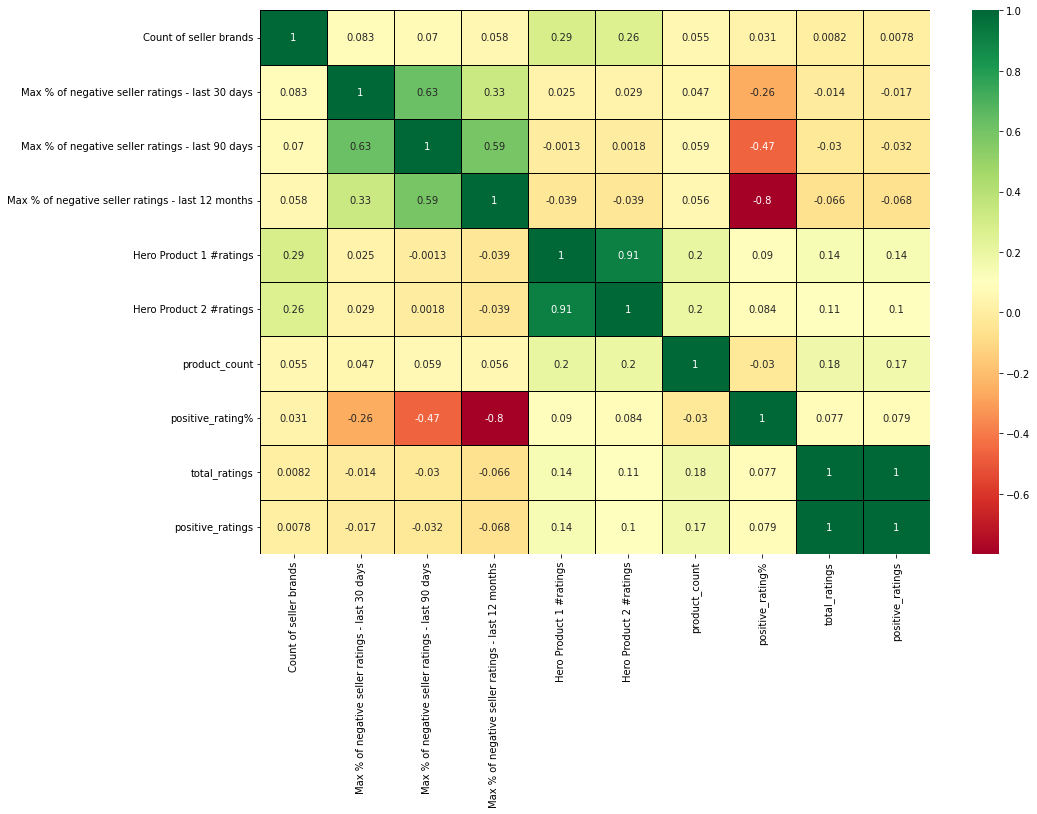

In [10]:
corr_columns = list(data.select_dtypes(include=["float64", "int64"]).columns)

fig = sns.heatmap(
    data[corr_columns].corr(),
    annot=True,
    cmap="RdYlGn",
    annot_kws={"size": 10},
    linecolor="black",
    linewidths=1,
)
fig = plt.gcf()
fig.set_size_inches(15, 10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

1. total_ratings and positive_ratings are obviously correlated
2. Hero product 1 and 2 ratings are highly correlated (91%)
3. Since product_count and total_ratings are not correlated, we can't use them to fill each other's NaNs
4. Count of Seller Brands is a little correlated with the Hero Product Rating, which is quite intutive but not useful at the moment
4. Max % negatve ratings across months are also intutively correlated:
    - 1 month and 3 month by 63%
    - 3 month and 12 month by 59%
    - 1 month and 12 month by 33%
    
    Since these negative ratings are correlated on the time dimension,
    we can assign them hand-crafted weights in the overall ranking calculation
    to reflect recency factor in the ratings.

# Weighted Score of Max % of negative seller ratings - last n days

In [11]:
"""
creating one score as a 
weighted average of negative seller ratings 
from the past 1, 3, and 12 months
"""


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


weights = np.array([1, 1 / 3, 1 / 12])
alpha = 1.5

weights = softmax(alpha * weights)
cols = ["30 days", "90 days", "12 months"]


aggregate = [
    data[f"Max % of negative seller ratings - last {col}"] * weights[idx]
    for idx, col in enumerate(cols)
]

concatenated_series = pd.concat(aggregate, axis=1)
data["% negative ratings"] = concatenated_series.sum(axis=1)

data.head(5)

,sellerlink,Count of seller brands,Max % of negative seller ratings - last 30 days,Max % of negative seller ratings - last 90 days,Max % of negative seller ratings - last 12 months,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,positive_rating%,total_ratings,positive_ratings,% negative ratings
0,Seller 1,16,17,11,12,5873,4957,United States,10580-1410,100000.0,88.0,118.0,103.84,14.858065
1,Seller 2,0,2,2,9,0,0,Germany,17213,NaN,90.0,566.0,509.40,3.092032
2,Seller 3,15,0,25,12,164,162,China,226000,2000.0,85.0,75.0,63.75,7.546688
3,Seller 4,1,0,0,0,0,0,China,450000,123.0,NaN,NaN,NaN,0.000000
4,Seller 5,16,0,31,15,224,113,China,518000,1000.0,81.0,52.0,42.12,9.376614


In [12]:
for col in cols:
    del data[f"Max % of negative seller ratings - last {col}"]

data.head(2)

,sellerlink,Count of seller brands,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,positive_rating%,total_ratings,positive_ratings,% negative ratings
0,Seller 1,16,5873,4957,United States,10580-1410,100000.0,88.0,118.0,103.84,14.858065
1,Seller 2,0,0,0,Germany,17213,NaN,90.0,566.0,509.40,3.092032


# Fixing Confidence Biases

In [13]:
"""
Example:

    Seller A: 300 positive ratings, 500 total ratings => 60% positive rate
    Seller B: 1 positive rating, 1 total ratings => 100% positive rate

Though Seller B has a positive rate > than that of Seller A
But we should have more confidence in Seller A, because we have more data for him.
"""

zero_average = 0.5

ratings_prior_ab = data["total_ratings"].mean()
ratings_prior_a = zero_average * ratings_prior_ab

data["corrected_positive_rating%"] = (
    100
    * (ratings_prior_a + data["positive_ratings"])
    / (ratings_prior_ab + data["total_ratings"])
)
data

,sellerlink,Count of seller brands,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,positive_rating%,total_ratings,positive_ratings,% negative ratings,corrected_positive_rating%
0,Seller 1,16,5873,4957,United States,10580-1410,100000.0,88.0,118.0,103.84,14.858065,64.009801
1,Seller 2,0,0,0,Germany,17213,NaN,90.0,566.0,509.40,3.092032,79.476800
2,Seller 3,15,164,162,China,226000,2000.0,85.0,75.0,63.75,7.546688,59.474425
3,Seller 4,1,0,0,China,450000,123.0,NaN,NaN,NaN,0.000000,NaN
4,Seller 5,16,224,113,China,518000,1000.0,81.0,52.0,42.12,9.376614,56.344916
...,...,...,...,...,...,...,...,...,...,...,...,...
1834,Seller 1835,5,95,76,China,518000,2000.0,83.0,46.0,38.18,4.382937,56.119446
1835,Seller 1836,0,1,0,China,050000,5000.0,NaN,NaN,NaN,0.000000,NaN
1836,Seller 1837,10,1,1,China,475300,10000.0,0.0,1.0,0.00,0.000000,49.753769
1837,Seller 1838,4,9,1,China,710000,473.0,67.0,3.0,2.01,5.148151,50.248706


In [14]:
del data["positive_rating%"]
data.head(2)

,sellerlink,Count of seller brands,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,total_ratings,positive_ratings,% negative ratings,corrected_positive_rating%
0,Seller 1,16,5873,4957,United States,10580-1410,100000.0,118.0,103.84,14.858065,64.009801
1,Seller 2,0,0,0,Germany,17213,NaN,566.0,509.40,3.092032,79.476800


# Binning Sellers Based on their Product Count

/tmp/ipykernel_331210/2564192523.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=median_imputed, shade=True, color="blue")


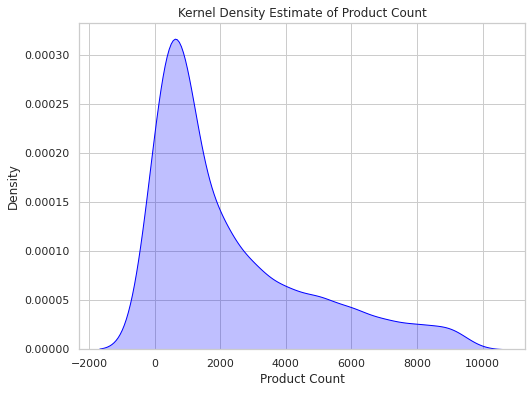

In [15]:
# Remove NaN values or impute them with a specific value
median_imputed = data[data["product_count"] < 10000]["product_count"].dropna()

# Create a KDE plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.kdeplot(data=median_imputed, shade=True, color="blue")

# Add labels and title
plt.xlabel("Product Count")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of Product Count")

# Show the plot
plt.show()

#### Since the distribution is skewed, let's replace nans with Median values of the geography

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sellerlink                  1839 non-null   object 
 1   Count of seller brands      1839 non-null   int64  
 2   Hero Product 1 #ratings     1839 non-null   int64  
 3   Hero Product 2 #ratings     1839 non-null   int64  
 4   country                     1764 non-null   object 
 5   zipcode                     1698 non-null   object 
 6   product_count               1513 non-null   float64
 7   total_ratings               1411 non-null   float64
 8   positive_ratings            1411 non-null   float64
 9   % negative ratings          1839 non-null   float64
 10  corrected_positive_rating%  1411 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 158.2+ KB


In [17]:
# calculate median for each country
median_by_country = data.groupby("country")["product_count"].transform("median")
data["product_count"] = data["product_count"].fillna(median_by_country)

# fill remaining NaN values with the median of the full product_count column
global_median = data["product_count"].median()
data["product_count"] = data["product_count"].fillna(global_median)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sellerlink                  1839 non-null   object 
 1   Count of seller brands      1839 non-null   int64  
 2   Hero Product 1 #ratings     1839 non-null   int64  
 3   Hero Product 2 #ratings     1839 non-null   int64  
 4   country                     1764 non-null   object 
 5   zipcode                     1698 non-null   object 
 6   product_count               1839 non-null   float64
 7   total_ratings               1411 non-null   float64
 8   positive_ratings            1411 non-null   float64
 9   % negative ratings          1839 non-null   float64
 10  corrected_positive_rating%  1411 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 158.2+ KB


In [19]:
percentile = lambda p: np.percentile(data.product_count, p)
q25, q50, q75 = percentile(25), percentile(50), percentile(75)

buckets = [0, q25, q50, q75, float("inf")]
bucket_labels = ["small", "medium", "large", "giant"]

data["seller_size"] = pd.cut(data["product_count"], bins=buckets, labels=bucket_labels)
data.head(5)

,sellerlink,Count of seller brands,Hero Product 1 #ratings,Hero Product 2 #ratings,country,zipcode,product_count,total_ratings,positive_ratings,% negative ratings,corrected_positive_rating%,seller_size
0,Seller 1,16,5873,4957,United States,10580-1410,100000.0,118.0,103.84,14.858065,64.009801,giant
1,Seller 2,0,0,0,Germany,17213,797.0,566.0,509.40,3.092032,79.476800,small
2,Seller 3,15,164,162,China,226000,2000.0,75.0,63.75,7.546688,59.474425,medium
3,Seller 4,1,0,0,China,450000,123.0,NaN,NaN,0.000000,NaN,small
4,Seller 5,16,224,113,China,518000,1000.0,52.0,42.12,9.376614,56.344916,medium


# Geography Analysis

In [44]:
def bar_plot(data, X, Y, mode="count", figsize=(30, 15)):
    """
    Count of Y for every X
    """
    group = data.groupby(X)[Y]
    group = group.mean() if mode == "mean" else group.count()
    group = group.reset_index()

    x_axis = group[X]
    x_axis = ["\n".join(str(x).split(" ")) for x in x_axis]
    y_axis = group[Y]

    plt.figure(figsize=figsize)
    plt.xticks(fontsize=10, rotation=90)

    sns.barplot(x=x_axis, y=y_axis)
    plt.grid(color="black", linestyle="-", linewidth=1, alpha=0.3)
    plt.title(f"{Y} for every {X}")


def stacked_bar_plot(data, X, Y, figsize=(30, 15)):
    """
    # stacked bar plot
    # count of all possible values of Y for all possible X
    # Example - Count of Sellers (Y) for each Country (X)
    """
    # count of all possible values of Y for all possible X
    value_counts = data.groupby(X)[Y].value_counts().reset_index(name="count")

    # fill in 0 for missing values of X-Y pair
    x = value_counts[[X]].drop_duplicates()
    y = value_counts[[Y]].drop_duplicates()

    x["temp"] = 0
    y["temp"] = 0

    temp = pd.merge(x, y, on=["temp"])
    temp.drop(columns=["temp"], inplace=True)
    temp.sort_values(by=[X, Y], ascending=True, inplace=True)

    value_counts = temp.merge(value_counts, how="left")
    value_counts.fillna(0, inplace=True)
    del temp

    # get numerical count values for X-Y pairs as list
    x_axis = value_counts[X].unique()
    x_axis = ["\n".join(str(x).split(" ")) for x in x_axis]

    y_axis = [
        value_counts[value_counts[Y] == value]["count"].tolist()
        for value in value_counts[Y].unique()
    ]

    # plot the stacked bar graph
    plt.figure(figsize=figsize)
    plt.xticks(fontsize=10, rotation=0)

    for i, severity in enumerate(value_counts[Y].unique()):
        plt.bar(x_axis, y_axis[i], label=f"{Y} {severity}")

    plt.legend()

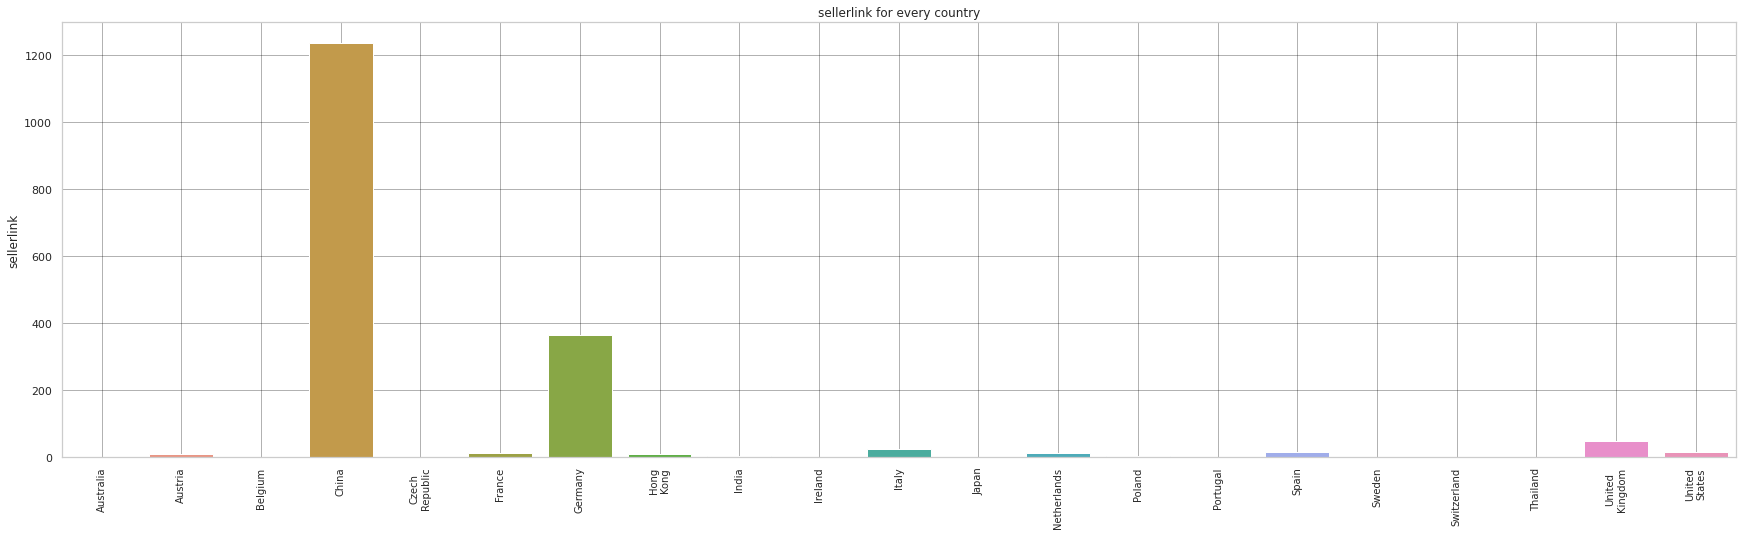

In [21]:
# Number of Sellers for every Country
bar_plot(data, Y="sellerlink", X="country", figsize=(30, 8))

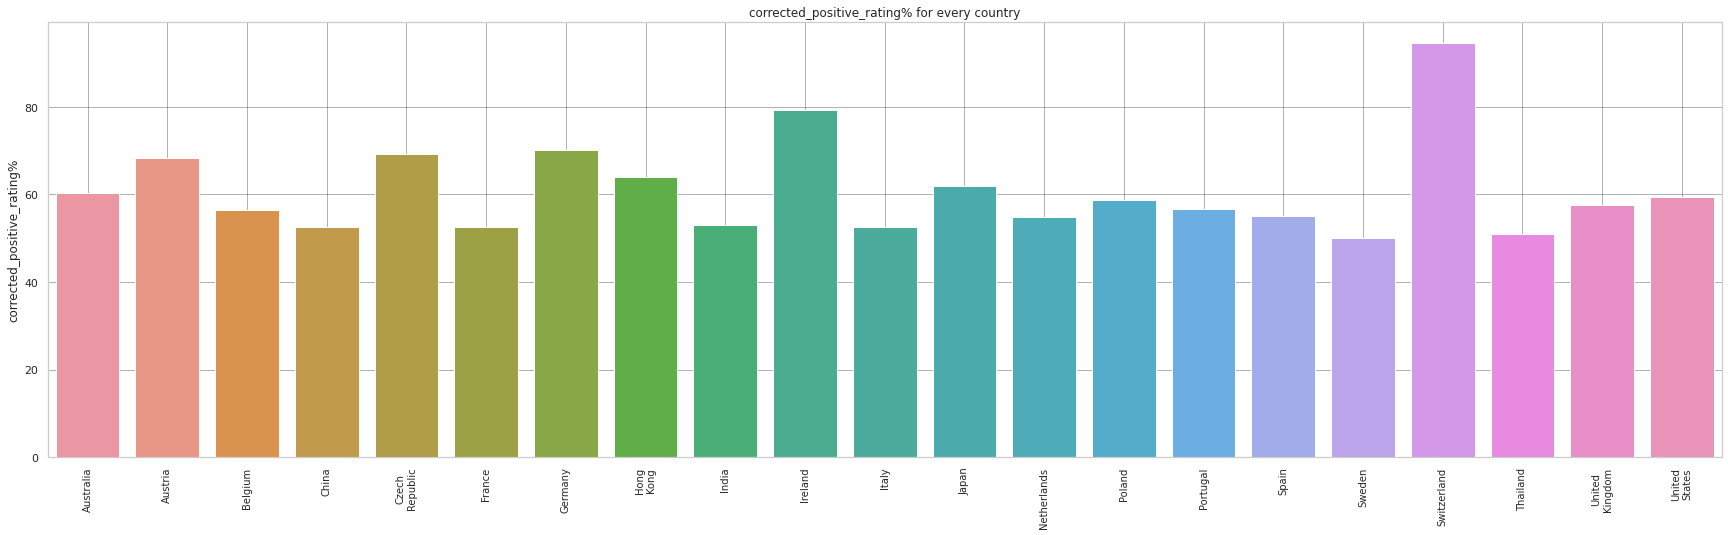

In [22]:
# mean positive rating % for sellers in every country
bar_plot(
    data, Y="corrected_positive_rating%", X="country", mode="mean", figsize=(30, 8)
)

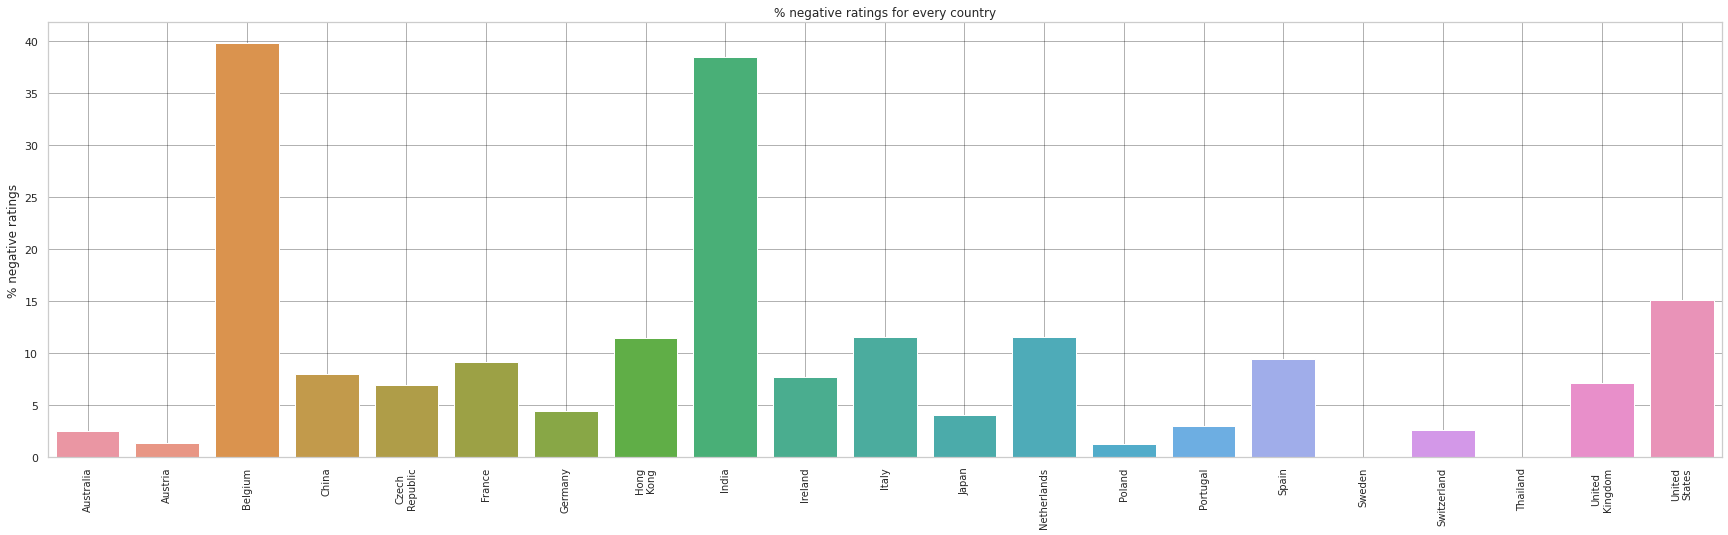

In [23]:
# mean negative rating % for sellers in every country
bar_plot(data, Y="% negative ratings", X="country", mode="mean", figsize=(30, 8))

#### 1. Belgium and India are the worst among seller ratings
#### 2. China has the most number of sellers
#### 3. Austria, Ireland and Switzerland have a good positive / negative rating balance

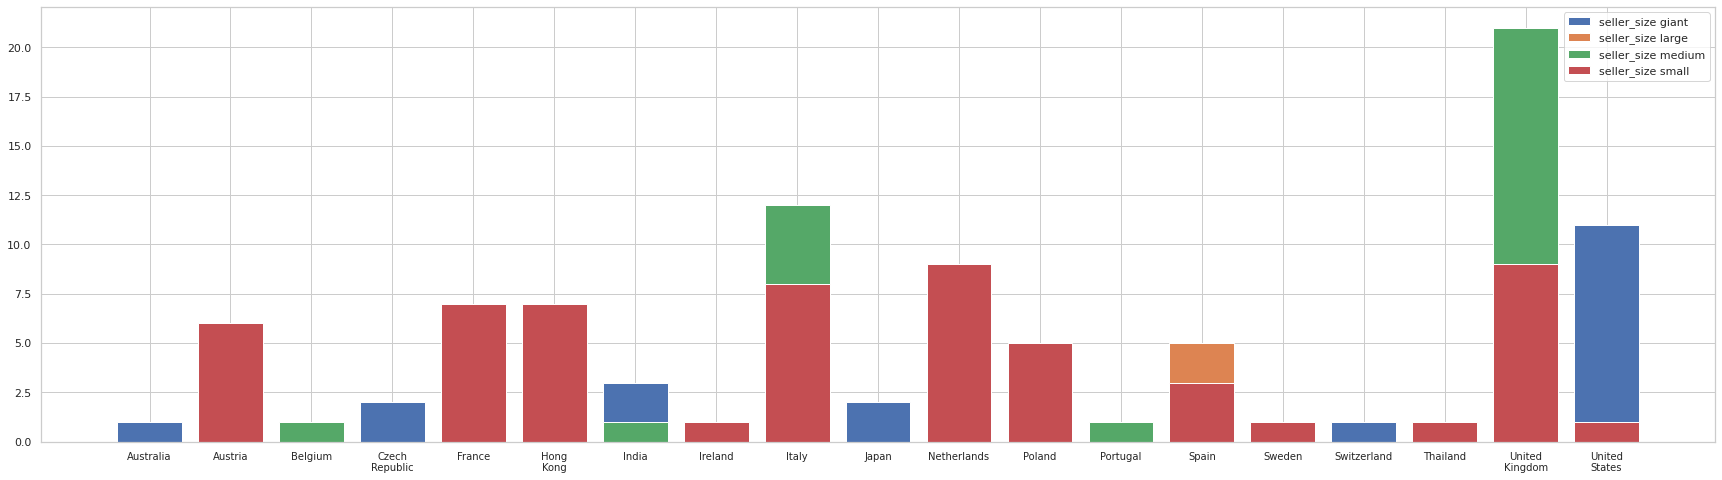

In [50]:
# count of Seller Sizes in each country
stacked_bar_plot(
    data[~data["country"].isin(["China", "Germany"])],
    X="country",
    Y="seller_size",
    figsize=(30, 8),
)

#### Ireland and Austria have all small sellers
#### Since their ratings are good, something similar can be concluded for "Small Sellers" as a seller class
#### Also, India and Belgium have no small sellers
#### Let's see!

# Seller Size Analysis

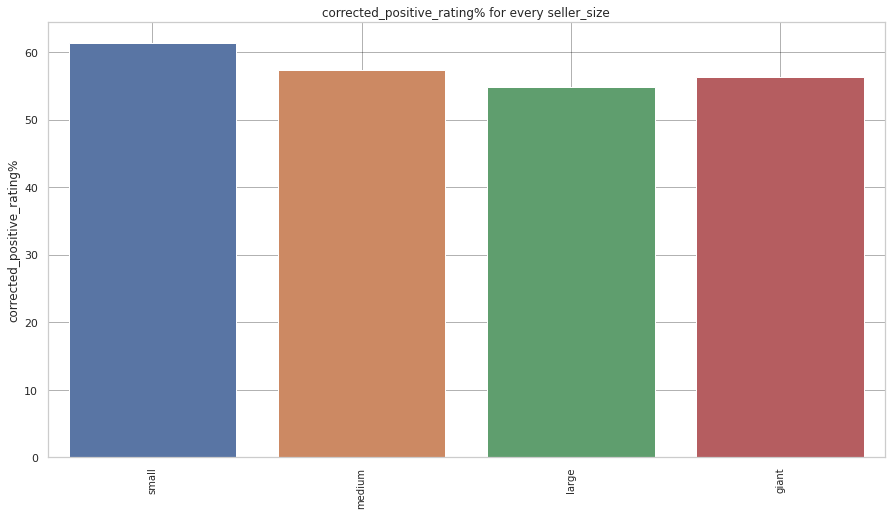

In [27]:
# mean positive rating % for sellers sizes
bar_plot(
    data, Y="corrected_positive_rating%", X="seller_size", mode="mean", figsize=(15, 8)
)

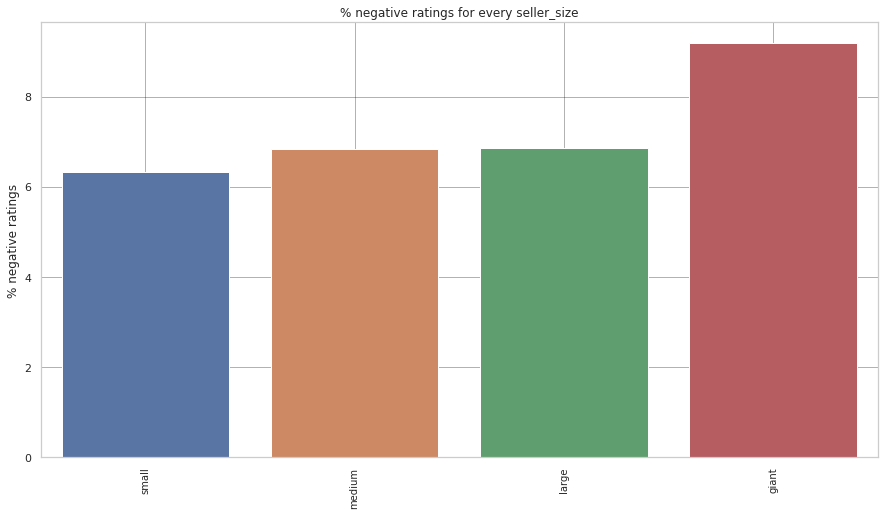

In [28]:
# mean negative rating % for sellers in every country
bar_plot(data, Y="% negative ratings", X="seller_size", mode="mean", figsize=(15, 8))

#### Looks like we were right after all!
#### Small sellers do care more about their users

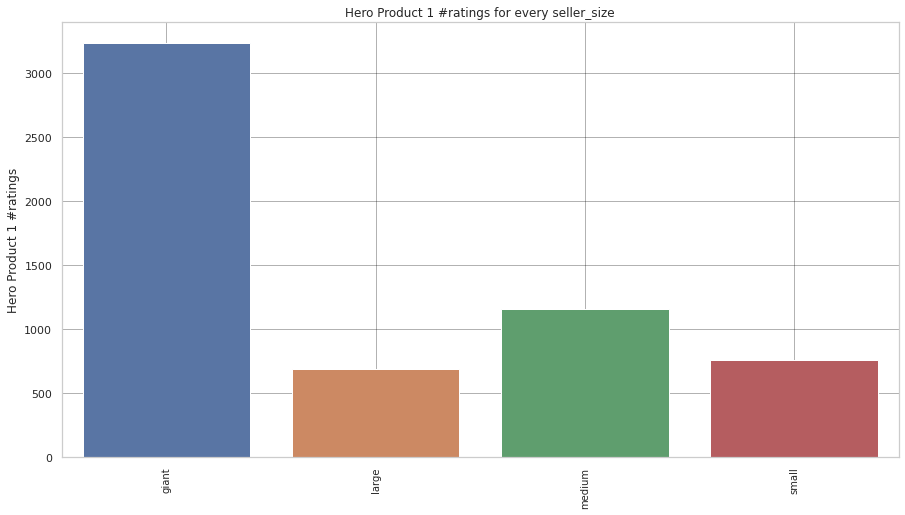

In [53]:
# average number of hero product rating for seller size
bar_plot(
    data, Y="Hero Product 1 #ratings", X="seller_size", mode="mean", figsize=(15, 8)
)

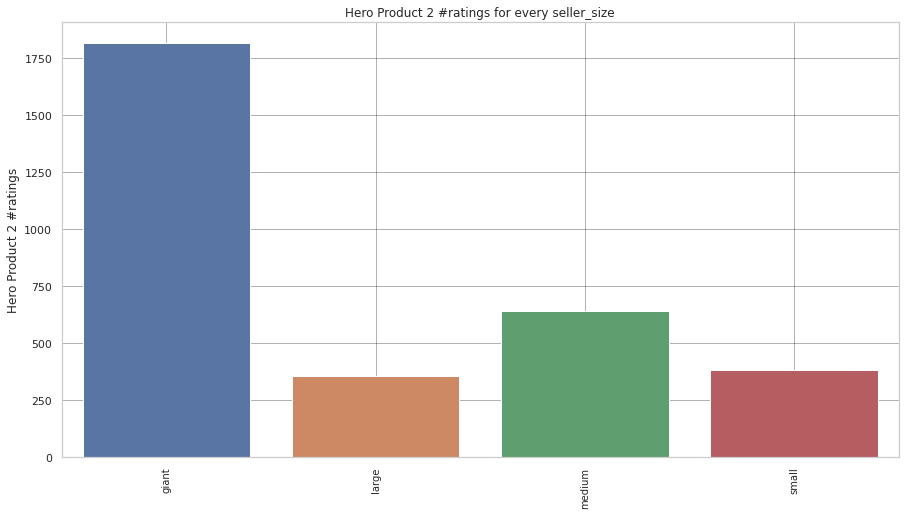

In [54]:
# average number of hero product rating for seller size
bar_plot(
    data, Y="Hero Product 2 #ratings", X="seller_size", mode="mean", figsize=(15, 8)
)

#### Giants are giants because of their Hero Product Sale

# Country Level Zipcode Analysis

In [59]:
# Zipcode Analysis for Austria and India
negative = lambda x: bar_plot(
    data[data["country"] == x],
    Y="% negative ratings",
    X="zipcode",
    mode="mean",
    figsize=(30, 8),
)
positive = lambda x: bar_plot(
    data[data["country"] == x],
    Y="corrected_positive_rating%",
    X="zipcode",
    mode="mean",
    figsize=(15, 8),
)

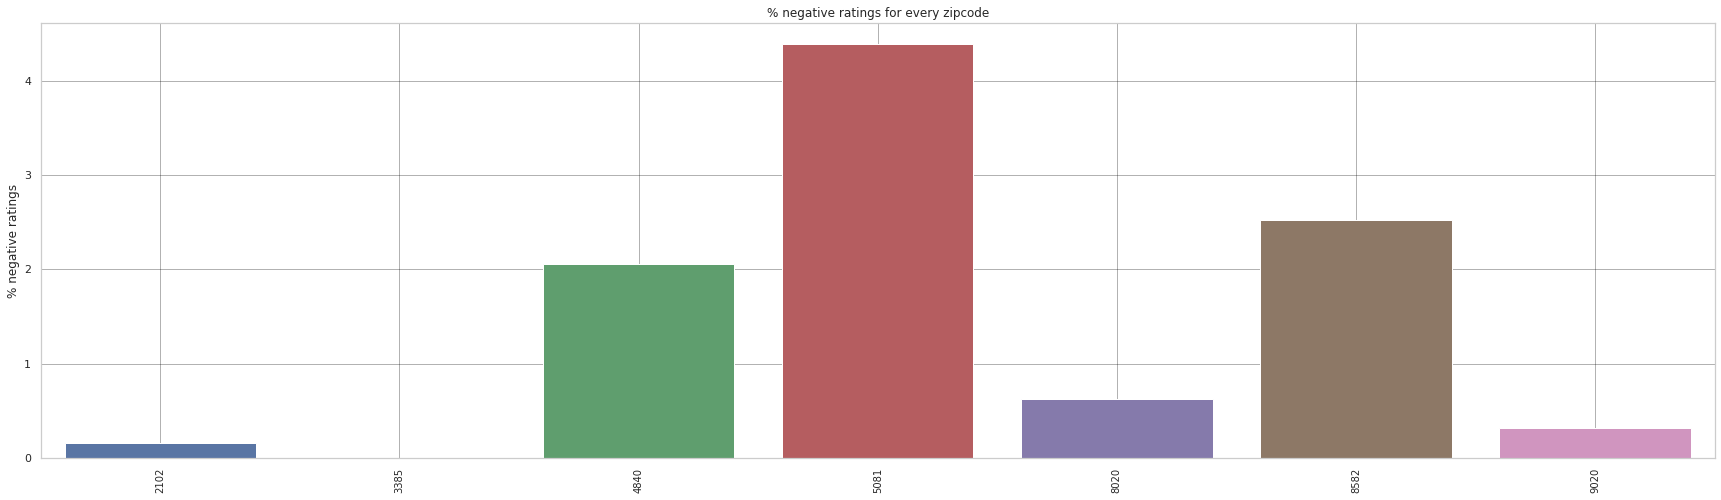

In [60]:
# mean negative rating % for Austria
negative("Austria")

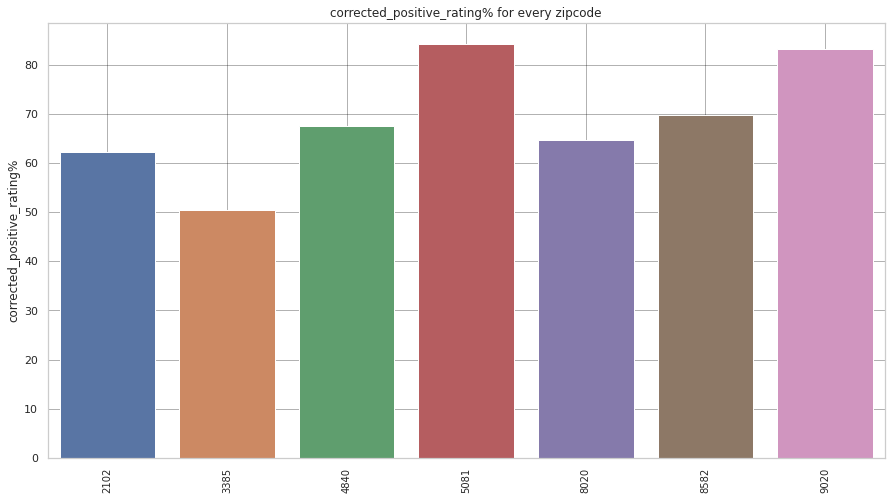

In [61]:
# mean positive rating % for Austria
positive("Austria")

#### 9020, 2102 and 3385 Austria Zipcode seem extremely good!

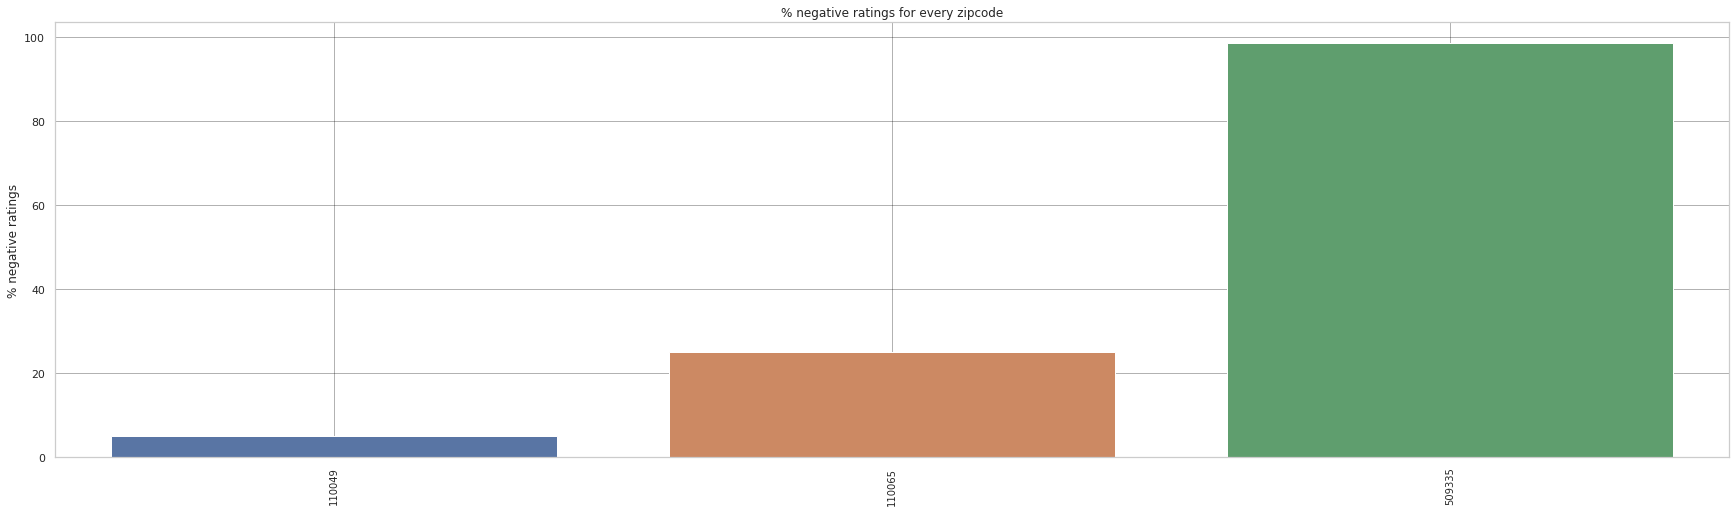

In [66]:
# mean negative rating % for India
negative("India")

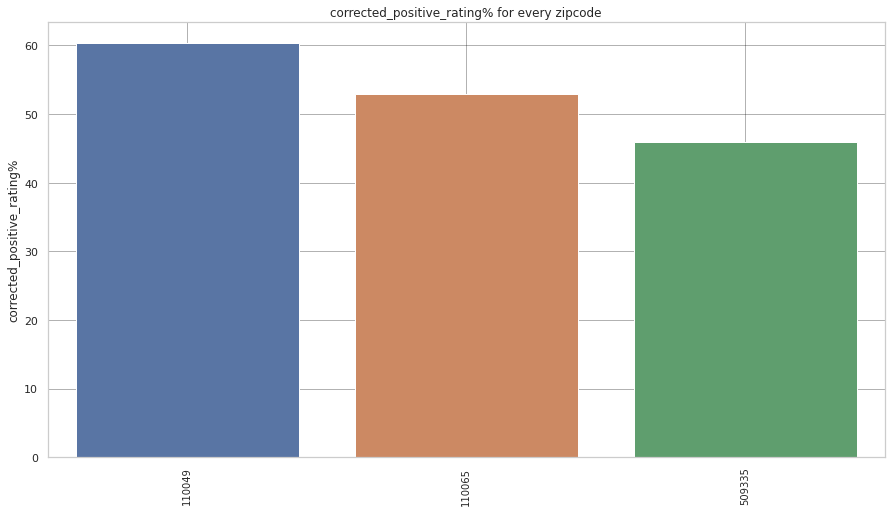

In [67]:
# mean positive rating % for India
positive("India")

#### 110049 zipcode in Delhi seem to be the best choice in India

# Country Level Seller Analysis

In [70]:
negative = lambda x: bar_plot(
    data[data["country"] == x],
    Y="% negative ratings",
    X="sellerlink",
    mode="mean",
    figsize=(30, 8),
)
positive = lambda x: bar_plot(
    data[data["country"] == x],
    Y="corrected_positive_rating%",
    X="sellerlink",
    mode="mean",
    figsize=(15, 8),
)

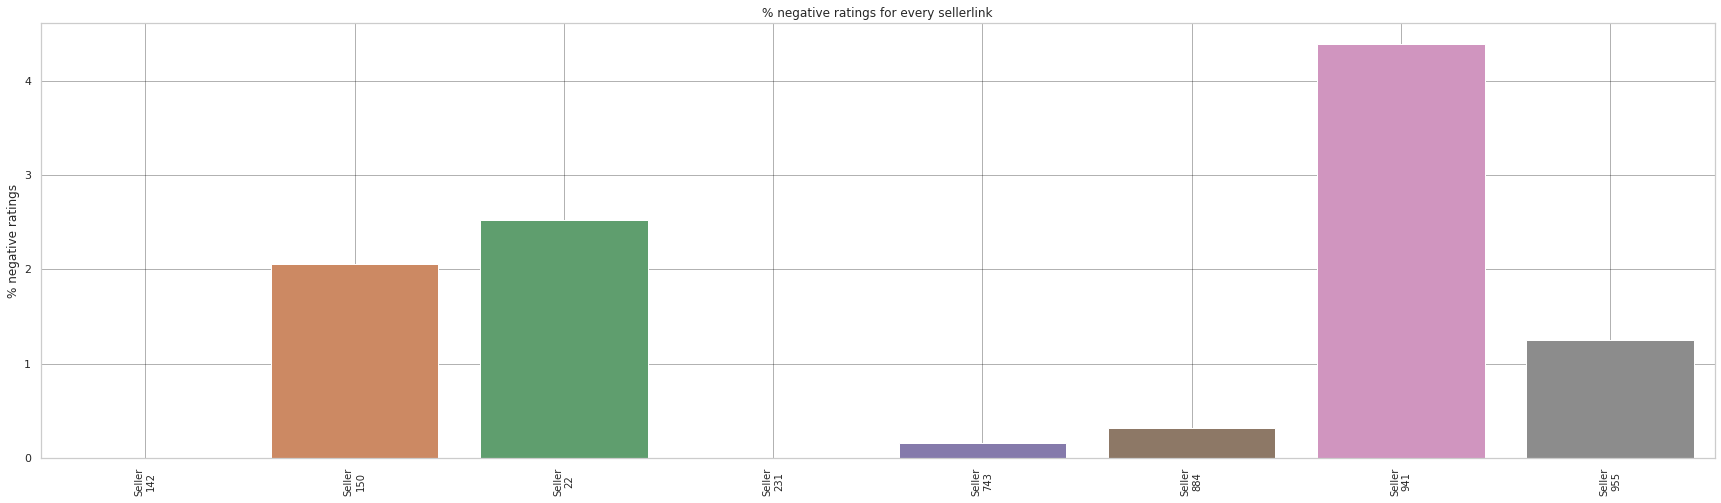

In [71]:
negative("Austria")

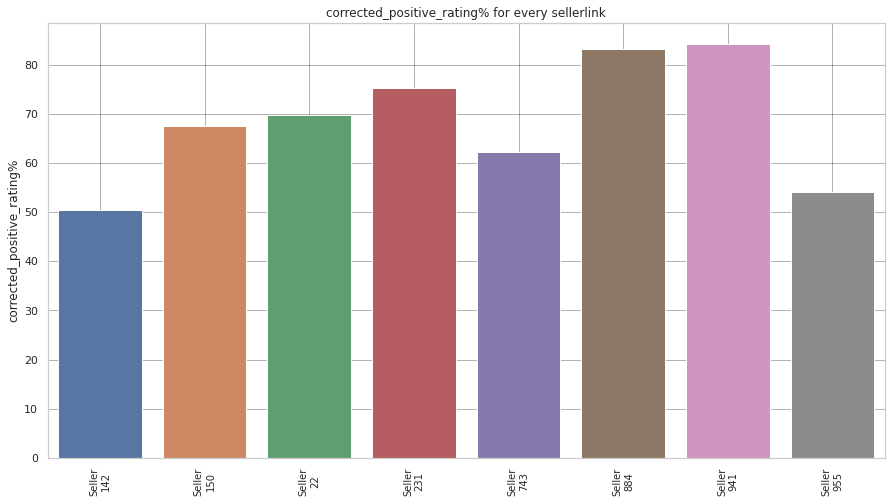

In [73]:
positive("Austria")

#### Seller 231, 884 and 941 seem very attractive in Austria

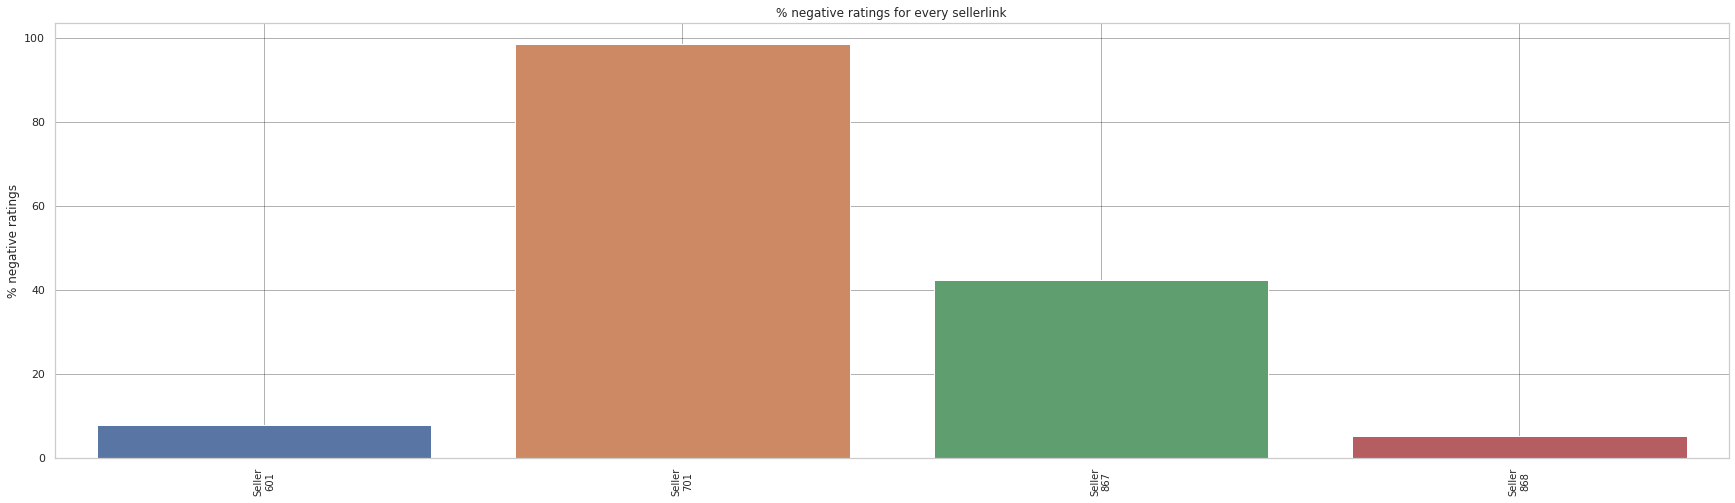

In [74]:
negative("India")

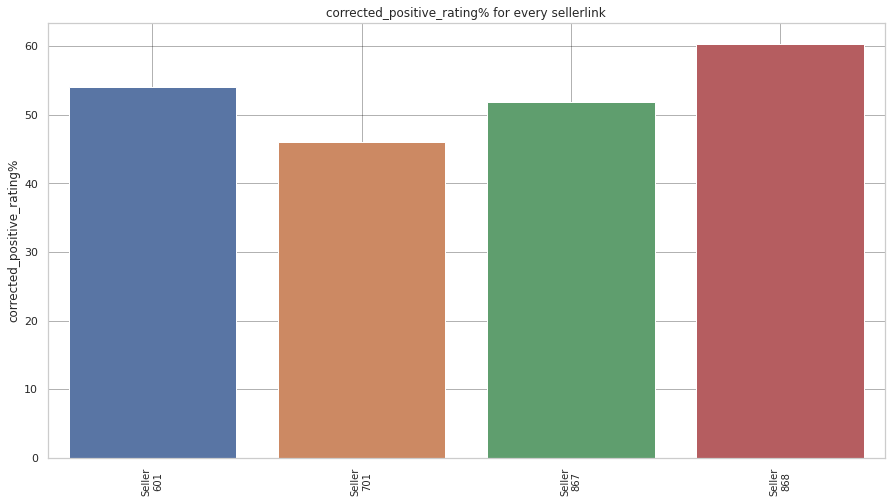

In [75]:
positive("India")

#### Sellers 868 and 601 seem very attractive in India